### Try It: Comparing Feature Selection Methods

In this module, you have seen two ways to select features.  The first approach is using sequential feature selection to sequentially add or delete features and only use those that improve the model.  The second approach is using a regularized model to identify features based on non-zero coefficients.  This activity focuses on comparing variations of both these methods.  

You will use both the `SequentialFeatureSelection` and `RFE` (recursive feature elimination) to build and compare regression models.  Consider the following 6 feature selection methods -- leave all other arguments to default besides the `estimator` and `n_features_to_select` arguments:

- `Ridge` regressor to extract coefficients
- `SequentialFeatureSelection` using the `Lasso` to select 4 features.
- `RFE` using `Lasso` to select 4 features.

For each of these, fit the training data `X_train`, `y_train` below.  Compare the magnitude of the results of your `Ridge` model to those that result from feature selection methods.  

#### The Data

For this problem a dataset with information on red wine chemical compositions and their quality is given.  Your goal is to use the properties of the wine to predict the quality.  Below, the data is loaded and train/test splits constructed.

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from Modules import cprint

In [121]:
df = pd.read_csv('data/winequality-red.csv', sep = ',')
results_dict = {}

In [122]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [123]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('quality', axis = 1))
X = pd.DataFrame(X, columns = scaler.get_feature_names_out())
y = df['quality']

In [124]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246


<Axes: >

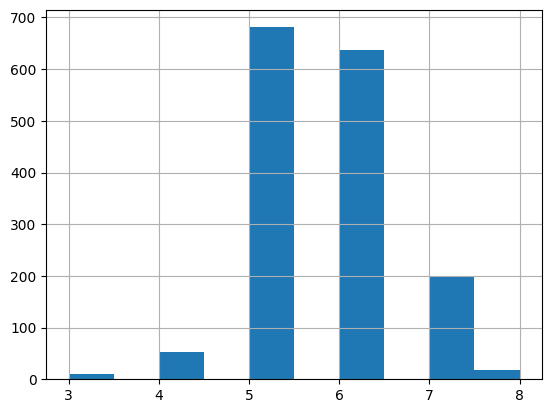

In [125]:
y.hist()

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [127]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector, RFE

# Ridge regression
Getting model coefficients with `Ridge()`

In [128]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [129]:
ridge_train_mse = mean_squared_error(ridge.predict(X_train), y_train)
ridge_test_mse = mean_squared_error(ridge.predict(X_test), y_test)

In [156]:
ridge.coef_
cprint("Ridge coefficients: " + ", ".join(str(round(i, ndigits=3)) for i in ridge.coef_), 'green')

ridge_dict = {'coef': ridge.coef_, 'train_mse': ridge_train_mse, 'test_mse': ridge_test_mse}
results_dict['ridge'] = ridge_dict
print(ridge_dict)

Ridge coefficients: 0.038, -0.18, -0.026, 0.013, -0.083, 0.052, -0.12, -0.031, -0.053, 0.139, 0.304
{'coef': array([ 0.03848027, -0.18035805, -0.02577449,  0.01266038, -0.08256489,
        0.0521999 , -0.12002362, -0.03121309, -0.05266487,  0.13890781,
        0.30435113]), 'train_mse': 0.4274188454982166, 'test_mse': 0.38830950723949564}


In [157]:
pd.DataFrame({'coefficients': ridge.coef_}, index = X_train.columns).transpose()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
coefficients,0.03848,-0.180358,-0.025774,0.01266,-0.082565,0.0522,-0.120024,-0.031213,-0.052665,0.138908,0.304351


# SequentialFeatureSelector

In [131]:
sfs = SequentialFeatureSelector(estimator = Lasso(), n_features_to_select=4)
sfs_model = sfs.fit_transform(X_train, y_train)
sfs

SequentialFeatureSelector(estimator=Lasso(), n_features_to_select=4)

In [132]:
sfs_feature_names = sfs.get_feature_names_out()
sfs_df = pd.DataFrame(sfs_model, columns = sfs_feature_names)
sfs_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar
0,1.942121,-0.211283,1.124700,-0.240375
1,0.275983,0.403229,0.097691,-0.240375
2,-0.700719,0.347364,-1.391472,-0.311323
3,-0.011282,0.068040,-0.159061,0.610998
4,0.563248,1.380862,-0.005010,0.185312


In [136]:
X_sfs_lasso = X_train[sfs_feature_names]
sfs_lasso = Ridge()
sfs_lasso_model = sfs_lasso.fit(X_sfs_lasso, y_train)
sfs_lasso_model

Ridge()

In [134]:
sfs_train_mse = mean_squared_error(sfs_lasso_model.predict(X_sfs_lasso), y_train)
sfs_test_mse = mean_squared_error(sfs_lasso_model.predict(X_test[sfs_feature_names]), y_test)

In [150]:
cprint("SFS features: " + ", ".join(i for i in sfs_feature_names), 'green')

sfs_lasso_dict = {'features': sfs_feature_names, 'coefficients': sfs_lasso_model.coef_, 'train_mse': sfs_train_mse, 'test_mse': sfs_test_mse}
results_dict['sfs_lasso'] = sfs_lasso_dict

sfs_lasso_dict

SFS features: fixed acidity, volatile acidity, citric acid, residual sugar


{'features': array(['fixed acidity', 'volatile acidity', 'citric acid',
        'residual sugar'], dtype=object),
 'coefficients': array([ 0.02585097, -0.30733508, -0.0186281 ,  0.00715591]),
 'train_mse': 0.568682598513795,
 'test_mse': 0.5021603519662515}

In [158]:
pd.DataFrame({'coefficients': sfs_lasso_model.coef_}, index = sfs_feature_names).transpose()

,fixed acidity,volatile acidity,citric acid,residual sugar
coefficients,0.025851,-0.307335,-0.018628,0.007156


# RFE

In [142]:
rfe = RFE(estimator = Lasso(), n_features_to_select=4)
rfe_model = rfe.fit_transform(X_train, y_train)
rfe

RFE(estimator=Lasso(), n_features_to_select=4)

In [143]:
rfe_feature_names = rfe.get_feature_names_out()
rfe_df = pd.DataFrame(rfe_model, columns = rfe_feature_names)
rfe_df.head()

,density,pH,sulphates,alcohol
0,1.724305,-0.784726,-1.346377,-1.147981
1,1.088288,0.316751,-0.992298,-1.241848
2,-0.989366,0.705508,-0.638220,1.010966
3,0.452272,-0.266384,-0.284141,-0.960246
4,0.876283,-0.007213,0.069937,0.166161


In [145]:
X_rfe_lasso = X_train[rfe_feature_names]
rfe_lasso = Ridge()
rfe_lasso_model = rfe_lasso.fit(X_rfe_lasso, y_train)

In [146]:
rfe_train_mse = mean_squared_error(rfe_lasso_model.predict(X_rfe_lasso), y_train)
rfe_test_mse = mean_squared_error(rfe_lasso_model.predict(X_test[rfe_feature_names]), y_test)

In [151]:
cprint("RFE features: " + ", ".join(i for i in rfe_feature_names), 'green')

rfe_lasso_dict = {'features': rfe_feature_names, 'coef': rfe_lasso_model.coef_, 'train_mse': rfe_train_mse, 'test_mse': rfe_test_mse}
results_dict['rfe_lasso'] = rfe_lasso_dict

rfe_lasso_dict

RFE features: density, pH, sulphates, alcohol


{'features': array(['density', 'pH', 'sulphates', 'alcohol'], dtype=object),
 'coef': array([-0.00483866, -0.08261023,  0.13011238,  0.39942127]),
 'train_mse': 0.47635937214936674,
 'test_mse': 0.4430644847605295}

In [159]:
pd.DataFrame({'coefficients': rfe_lasso_model.coef_}, index = rfe_feature_names).transpose()

,density,pH,sulphates,alcohol
coefficients,-0.004839,-0.08261,0.130112,0.399421


In [152]:
results_dict

{'ridge': {'coef': array([ 0.03848027, -0.18035805, -0.02577449,  0.01266038, -0.08256489,
          0.0521999 , -0.12002362, -0.03121309, -0.05266487,  0.13890781,
          0.30435113]),
  'train_mse': 0.4274188454982166,
  'test_mse': 0.38830950723949564},
 'sfs_lasso': {'features': array(['fixed acidity', 'volatile acidity', 'citric acid',
         'residual sugar'], dtype=object),
  'coefficients': array([ 0.02585097, -0.30733508, -0.0186281 ,  0.00715591]),
  'train_mse': 0.568682598513795,
  'test_mse': 0.5021603519662515},
 'rfe_lasso': {'features': array(['density', 'pH', 'sulphates', 'alcohol'], dtype=object),
  'coef': array([-0.00483866, -0.08261023,  0.13011238,  0.39942127]),
  'train_mse': 0.47635937214936674,
  'test_mse': 0.4430644847605295}}